In [259]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.signal as signal
import scipy.fft as fft


In [260]:
fs = 1000

# Filter functions

## High pass

### Attributes
- cutoff: 20 Hz
- order: 4

In [261]:
def highpass_filter(data, cutoff=20, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

## Notch

### Attributes
- cutoff_low: 48 Hz
- cutoff_high: 52 Hz
- order: 2

In [262]:
def notch_filter(data, freq_a = 48, freq_b = 52, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq_normalized_a = freq_a / nyquist
    freq_normalized_b = freq_b / nyquist
    b, a = signal.butter(2, [freq_normalized_a, freq_normalized_b], btype='bandstop')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

## Bandpass

### Attributes
- cutoff_low: 20 Hz
- cutoff_high: 450 Hz
- order: 4

In [263]:
def bandpass_filter(data, low=20, high=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low_normalized = low / nyquist
    high_normalized = high / nyquist
    b, a = signal.butter(order, [low_normalized, high_normalized], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

## Low Pass

### Attributes
- cutoff: 5 Hz
- order: 4

In [264]:
def lowpass_filter(data, cutoff=5, fs=1000, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    envelope = signal.filtfilt(b, a, data)
    return envelope

In [286]:
# Load data
df = pd.read_csv('./Datasets/hemanth_test_bicep.csv')

# Choose features
imu_features = [
    'accel_y', 'accel_x', 'accel_z',
    'gyro_x', 'gyro_z', 'gyro_y'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [287]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# Option 1: Windowed WaveNet with Global Context
class WindowedWaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2, window_size=64):
        super(WindowedWaveNet, self).__init__()
        self.window_size = window_size
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        # WaveNet blocks with increasing dilation
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        
        # Global context layer to capture long-range dependencies
        self.global_context = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Conv1d(hidden_channels, hidden_channels // 4, 1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels // 4, hidden_channels, 1),
            nn.Sigmoid()
        )
        
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        batch_size, seq_len, features = x.shape
        
        # Pad sequence for windowing if needed
        if seq_len < self.window_size:
            padding = self.window_size - seq_len
            x = F.pad(x, (0, 0, 0, padding), mode='replicate')
            seq_len = self.window_size
        
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        
        # Process through WaveNet blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply global context attention
        context = self.global_context(x)
        x = x * context
        
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return x


# Option 2: WaveNet + Transformer Hybrid
class WaveNetTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, num_heads=8, dropout=0.1):
        super(WaveNetTransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            hidden_channels, num_heads, dropout=dropout, batch_first=True
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.norm2 = nn.LayerNorm(hidden_channels)
        
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels * 4, hidden_channels),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        # x: (batch_size, seq_len, hidden_channels)
        # Self-attention
        attn_out, _ = self.attention(x, x, x, key_padding_mask=mask)
        x = self.norm1(x + attn_out)
        
        # Feed-forward network
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        return x


class IMU2EMG_WaveNetTransformer(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_wavenet_blocks=3, 
                 num_transformer_blocks=2, num_heads=8, kernel_size=2, dropout=0.1):
        super(IMU2EMG_WaveNetTransformer, self).__init__()
        
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        # WaveNet blocks for local feature extraction
        self.wavenet_blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_wavenet_blocks)
        ])
        
        # Transformer blocks for global context
        self.transformer_blocks = nn.ModuleList([
            WaveNetTransformerBlock(hidden_channels, num_heads, dropout)
            for _ in range(num_transformer_blocks)
        ])
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(hidden_channels, dropout)
        
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x, pad_mask=None):
        # x: (batch_size, seq_len, imu_features)
        batch_size, seq_len, _ = x.shape
        
        # WaveNet processing
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        
        for block in self.wavenet_blocks:
            x = block(x)
        
        # Prepare for transformer
        x = x.transpose(1, 2)  # (batch_size, seq_len, hidden_channels)
        x = self.pos_encoding(x)
        
        # Transformer processing
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask=pad_mask)
        
        # Output
        x = x.transpose(1, 2)  # (batch_size, hidden_channels, seq_len)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return x


# Option 3: Sliding Window WaveNet (Fixed)
class SlidingWindowWaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, 
                 kernel_size=2, window_size=32):
        super(SlidingWindowWaveNet, self).__init__()
        self.window_size = window_size
        
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        
        # Context aggregation with same padding to preserve sequence length
        self.context_conv = nn.Conv1d(hidden_channels, hidden_channels, 
                                    kernel_size=window_size, stride=1, 
                                    padding=window_size//2)
        
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        original_seq_len = x.shape[1]
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        
        # Store original for skip connection
        skip_connections = []
        
        for block in self.blocks:
            x = block(x)
            skip_connections.append(x)
        
        # Combine skip connections
        skip_sum = sum(skip_connections)
        
        # Apply context-aware convolution
        x = self.context_conv(skip_sum)
        
        # Ensure output length matches input length
        if x.shape[2] != original_seq_len:
            x = x[:, :, :original_seq_len]
        
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()
        
        # Store residual connection
        residual = x
        
        # Apply layer norm first (pre-norm architecture)
        x = self.layer_norm(x)
        
        # Linear transformations and split into heads
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Apply mask if provided
        if mask is not None:
            # mask shape: (batch_size, seq_len) -> expand to (batch_size, num_heads, seq_len, seq_len)
            mask = mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
            mask = mask.expand(batch_size, self.num_heads, seq_len, seq_len)
            scores.masked_fill_(mask, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention to values
        context = torch.matmul(attention_weights, V)
        
        # Concatenate heads and apply output projection
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        output = self.W_o(context)
        
        # Residual connection
        return output + residual

class TransformerEnhancedWaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, 
                 kernel_size=2, window_size=32, num_transformer_layers=2, 
                 num_heads=8, dropout=0.1):
        super(TransformerEnhancedWaveNet, self).__init__()
        self.window_size = window_size
        self.hidden_channels = hidden_channels
        
        # Input projection
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        
        # WaveNet blocks for local context
        self.wavenet_blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        
        # Transformer layers for global context
        self.pos_encoding = PositionalEncoding(hidden_channels)
        self.transformer_layers = nn.ModuleList([
            MultiHeadSelfAttention(hidden_channels, num_heads, dropout)
            for _ in range(num_transformer_layers)
        ])
        
        # Context aggregation with sliding window
        self.context_conv = nn.Conv1d(hidden_channels, hidden_channels, 
                                    kernel_size=window_size, stride=1, 
                                    padding=window_size//2)
        
        # Feature fusion layer
        self.fusion_conv = nn.Conv1d(hidden_channels * 2, hidden_channels, kernel_size=1)
        self.fusion_norm = nn.BatchNorm1d(hidden_channels)
        self.fusion_activation = nn.ReLU()
        
        # Output projection
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, pad_mask=None):
        # x: (batch_size, seq_len, imu_features)
        # pad_mask: (batch_size, seq_len) - True for padded positions
        
        batch_size, original_seq_len, imu_features = x.shape
        
        # === WaveNet Path (Local Context) ===
        x_conv = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x_conv = self.input_conv(x_conv)
        
        # Store skip connections from WaveNet blocks
        skip_connections = []
        for block in self.wavenet_blocks:
            x_conv = block(x_conv)
            skip_connections.append(x_conv)
        
        # Combine skip connections
        wavenet_features = sum(skip_connections)
        
        # Apply sliding window context
        wavenet_features = self.context_conv(wavenet_features)
        
        # Ensure output length matches input length
        if wavenet_features.shape[2] != original_seq_len:
            wavenet_features = wavenet_features[:, :, :original_seq_len]
        
        # === Transformer Path (Global Context) ===
        # Use the initial conv features for transformer
        x_transformer = x_conv.transpose(1, 2)  # (batch_size, seq_len, hidden_channels)
        
        # Add positional encoding
        x_transformer = x_transformer.transpose(0, 1)  # (seq_len, batch_size, hidden_channels)
        x_transformer = self.pos_encoding(x_transformer)
        x_transformer = x_transformer.transpose(0, 1)  # (batch_size, seq_len, hidden_channels)
        
        # Apply transformer layers
        for transformer_layer in self.transformer_layers:
            x_transformer = transformer_layer(x_transformer, pad_mask)
        
        x_transformer = self.dropout(x_transformer)
        x_transformer = x_transformer.transpose(1, 2)  # (batch_size, hidden_channels, seq_len)
        
        # === Feature Fusion ===
        # Concatenate WaveNet and Transformer features
        fused_features = torch.cat([wavenet_features, x_transformer], dim=1)
        
        # Fusion layer to combine both contexts
        fused_features = self.fusion_conv(fused_features)
        fused_features = self.fusion_norm(fused_features)
        fused_features = self.fusion_activation(fused_features)
        
        # Final output projection
        output = self.output_conv(fused_features)
        output = output.transpose(1, 2)  # (batch_size, seq_len, 1)
        
        return output

class IMU2EMG_WaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2):
        super(IMU2EMG_WaveNet, self).__init__()
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        return x

# Utility classes

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetBlock, self).__init__()
        self.causal_conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.activation = nn.ReLU()
        self.residual_conv = nn.Conv1d(out_channels, in_channels, kernel_size=1)

    def forward(self, x):
        out = self.causal_conv(x)
        out = out[:, :, :-self.causal_conv.padding[0]]  # remove padding for causality
        out = self.activation(out)
        res = self.residual_conv(out)
        return res + x  # residual connection
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return self.dropout(x)

In [288]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [289]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)     # (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)     # (batch_size, max_seq_len, 1)

    # Create padding mask: shape (batch_size, max_seq_len)
    # False where there's real data, True where there's padding
    lengths = torch.tensor([x.shape[0] for x in imu_batch])
    max_len = imu_batch_padded.shape[1]
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)
    
    return imu_batch_padded, emg_batch_padded, pad_mask



In [290]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [291]:
# Recreate the model architecture
model = SlidingWindowWaveNet(imu_features=len(imu_features), hidden_channels=64, window_size=10, kernel_size=2, num_blocks=5)

model.load_state_dict(torch.load(f'./model_checkpoint/shubhranil/model_best_SlidingWindowWaveNet_mse_bicep.pth'))

<All keys matched successfully>

In [292]:
def predict_emg(model, imu_data, device):
    """
    Predict EMG from IMU data
    
    Args:
        model: Trained WaveNet model
        imu_data: numpy array of shape (seq_len, features) or (batch_size, seq_len, features)
        device: torch device
    
    Returns:
        numpy array of predicted EMG values
    """
    model.eval()
    
    # Convert to tensor
    if isinstance(imu_data, np.ndarray):
        imu_tensor = torch.tensor(imu_data, dtype=torch.float32)
    else:
        imu_tensor = imu_data
    
    # Add batch dimension if needed
    if len(imu_tensor.shape) == 2:
        imu_tensor = imu_tensor.unsqueeze(0)
    
    imu_tensor = imu_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(imu_tensor)
    
    # Convert to numpy and remove extra dimensions
    prediction_np = prediction.cpu().numpy().squeeze()
    
    return prediction_np  # Normalize to start from zero

In [293]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

seg_id = 12

scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
predicted_emg = predict_emg(model, imu_segments[seg_id], 'cpu')
true_emg = np.array(emg_segments[seg_id]).reshape(-1, 1)
pred_emg = predicted_emg.reshape(-1, 1)

# Fit scaler on both arrays concatenated to ensure same scale
scaler1.fit(true_emg)
scaler2.fit(pred_emg)
true_emg_norm = scaler1.transform(true_emg).flatten()
pred_emg_norm = scaler2.transform(pred_emg).flatten()

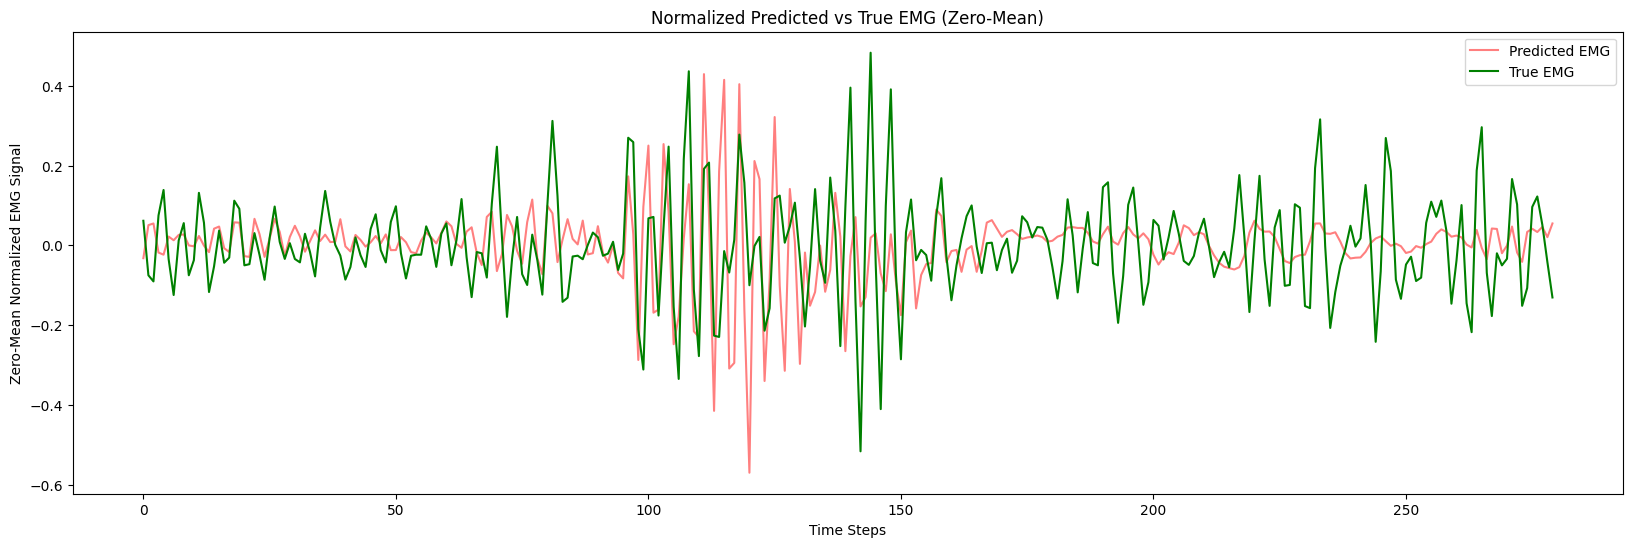

In [294]:
plt.figure(figsize=(20, 6))
plt.plot(pred_emg_norm - np.mean(pred_emg_norm), label='Predicted EMG', alpha=0.5, color='red')
plt.plot(true_emg_norm - np.mean(true_emg_norm), label='True EMG', color='green')
plt.title('Normalized Predicted vs True EMG (Zero-Mean)')
plt.xlabel('Time Steps')
plt.ylabel('Zero-Mean Normalized EMG Signal')
plt.legend()

In [295]:
pred_hp = highpass_filter(pred_emg.flatten(), cutoff=70, fs=fs)

pred_bp = bandpass_filter(pred_hp, low=20, high=300, fs=fs)

pred_notch = notch_filter(pred_bp, fs=fs)

Hilbert–Huang Transform (HHT)

In [296]:
from PyEMD import EMD
from scipy.signal import hilbert
from scipy.stats import pearsonr

# True values

# 1. Decompose signal into IMFs
imfs_true = EMD().emd(true_emg.flatten())
imfs_pred = EMD().emd(pred_emg.flatten())

# 2. Compute instantaneous amplitude/frequency
amp_true = np.abs(hilbert(imfs_true[0]))
amp_pred = np.abs(hilbert(imfs_pred[0]))
freq_true = np.diff(np.unwrap(np.angle(hilbert(imfs_true[0]))))
freq_pred = np.diff(np.unwrap(np.angle(hilbert(imfs_pred[0]))))

# 3. Compare instantaneous envelopes/frequencies (e.g., via correlation)
env_corr, _ = pearsonr(amp_true, amp_pred)
print('==== True values ====')
print(f"HHT instantaneous-envelope Pearson correlation: {env_corr:.4f}")


# Normalized values

# 1. Decompose signal into IMFs
imfs_true_norm = EMD().emd(true_emg_norm.flatten())
imfs_pred_norm = EMD().emd(pred_emg_norm.flatten())

# 2. Compute instantaneous amplitude/frequency
amp_true_norm = np.abs(hilbert(imfs_true_norm[0]))
amp_pred_norm = np.abs(hilbert(imfs_pred_norm[0]))
freq_true_norm = np.diff(np.unwrap(np.angle(hilbert(imfs_true_norm[0]))))
freq_pred_norm = np.diff(np.unwrap(np.angle(hilbert(imfs_pred_norm[0]))))

# 3. Compare instantaneous envelopes/frequencies (e.g., via correlation)
env_corr_norm, _ = pearsonr(amp_true_norm, amp_pred_norm)
print('==== Normalized values ====')
print(f"HHT instantaneous-envelope Pearson correlation: {env_corr_norm:.4f}")

==== True values ====
HHT instantaneous-envelope Pearson correlation: 0.3409
==== Normalized values ====
HHT instantaneous-envelope Pearson correlation: 0.3409


Short-Time Fourier Transform (STFT)

In [297]:
from scipy.signal import stft
from sklearn.metrics import mean_squared_error as mse

# True values

f_true, t_true, Zxx_true = stft(true_emg.flatten(), fs=1000, nperseg=len(true_emg.flatten()))
f_pred, t_pred, Zxx_pred = stft(pred_emg.flatten(), fs=1000, nperseg=len(pred_emg.flatten()))

# Then you can compute magnitude‐spectrogram MSE or coherence in each time–freq bin
magnitude_true = np.abs(Zxx_true)
magnitude_pred = np.abs(Zxx_pred)
mse_spec = mse(magnitude_true.flatten(), magnitude_pred.flatten())
print('==== True values ====')
print(f"STFT magnitude-spectrogram MSE: {mse_spec:.6f}")

# Normalized values

f_true_norm, t_true_norm, Zxx_true_norm = stft(true_emg_norm.flatten(), fs=1000, nperseg=len(true_emg_norm.flatten()))
f_pred_norm, t_pred_norm, Zxx_pred_norm = stft(pred_emg_norm.flatten(), fs=1000, nperseg=len(pred_emg_norm.flatten()))

# Then you can compute magnitude‐spectrogram MSE or coherence in each time–freq bin
magnitude_true_norm = np.abs(Zxx_true_norm)
magnitude_pred_norm = np.abs(Zxx_pred_norm)
mse_spec = mse(magnitude_true_norm.flatten(), magnitude_pred_norm.flatten())
print('==== Normalized values ====')
print(f"STFT magnitude-spectrogram MSE: {mse_spec:.6f}")

==== True values ====
STFT magnitude-spectrogram MSE: 3.470180
==== Normalized values ====
STFT magnitude-spectrogram MSE: 0.000050


Pearson Correlation Coefficient

In [298]:
print('PCC True :', np.corrcoef(true_emg.flatten(), pred_emg.flatten())[1, 0])
print('PCC Norm :', np.corrcoef(true_emg_norm.flatten(), pred_emg_norm.flatten())[1, 0])

PCC True : 0.2846607640695467
PCC Norm : 0.28466076096466075


Cosine Similarity

In [299]:
from sklearn.metrics.pairwise import cosine_similarity

print('Cosine Similarity True:', cosine_similarity(true_emg.reshape(1, -1), pred_emg.reshape(1, -1))[0, 0])
print('Cosine Similarity Norm:', cosine_similarity(true_emg_norm.reshape(1, -1), pred_emg_norm.reshape(1, -1))[0, 0])

Cosine Similarity True: 0.2831987239298541
Cosine Similarity Norm: 0.967566180395099


Correlation idea sir gave

In [300]:
import numpy as np
from scipy.signal import correlate

def normalized_cross_correlation(x_emg_norm, x_pre_norm):
    # Normalize both signals
    # x_emg_norm = x_emg / np.linalg.norm(x_emg)
    # x_pre_norm = x_pre / np.linalg.norm(x_pre)

    # Compute normalized cross-correlation
    corr = correlate(x_emg_norm, x_pre_norm, mode='full')
    lags = np.arange(-len(x_emg_norm) + 1, len(x_pre_norm))

    # Find the lag (index shift) where correlation is maximized
    tau_hat = lags[np.argmax(corr)]

    return tau_hat, corr, lags

def shift_signal(x, shift):
    """
    Shift signal by 'shift' samples using circular shift for now.
    For causal systems, you might want to pad instead.
    """
    if shift == 0:
        return x
    elif shift > 0:
        return np.concatenate((np.zeros(shift), x[:-shift]))
    else:
        return np.concatenate((x[-shift:], np.zeros(-shift)))

def compute_squared_error(x_emg, x_pre_shifted):
    # Normalize both
    x_emg_norm = x_emg / np.linalg.norm(x_emg)
    x_pre_norm = x_pre_shifted / np.linalg.norm(x_pre_shifted)

    # Compute squared error
    se = np.linalg.norm(x_emg_norm - x_pre_norm)**2
    return se

In [301]:
# Step 1: Find optimal delay (index shift)
tau_hat, _, _ = normalized_cross_correlation(true_emg_norm.flatten(), pred_emg_norm.flatten())

# Step 2: Shift x_pre back by tau_hat
x_pre_shifted = shift_signal(pred_emg_norm.flatten(), tau_hat)

# Step 3: Compute squared error
se = compute_squared_error(true_emg_norm.flatten(), x_pre_shifted)

print(f"Optimal shift (tau_hat): {tau_hat} samples")
print(f"Squared Error: {se:.6f}")

Optimal shift (tau_hat): 0 samples
Squared Error: 0.064868


Mwan Squared Error (MSE)

In [302]:
print("True MSE:", mean_squared_error(true_emg, pred_emg))
print("Normalized MSE:",mean_squared_error(true_emg_norm, pred_emg_norm))

True MSE: 978.8874656978529
Normalized MSE: 0.022218020325532533


In [303]:
# Compute FFT of true_emg and pred_emg
true_emg_flat = true_emg.flatten()
pred_emg_flat = pred_emg.flatten()

fft_true = np.fft.fft(true_emg_flat)
fft_pred = np.fft.fft(pred_emg_flat)

# Compute magnitude spectra
mag_true = np.abs(fft_true)
mag_pred = np.abs(fft_pred)

# Normalize magnitude spectra
mag_true_norm = mag_true / np.linalg.norm(mag_true)
mag_pred_norm = mag_pred / np.linalg.norm(mag_pred)

# Compute cosine similarity between the magnitude spectra
fft_similarity = cosine_similarity(mag_true_norm.reshape(1, -1), mag_pred_norm.reshape(1, -1))[0, 0]

print(f"FFT magnitude spectrum cosine similarity: {fft_similarity:.4f}")

FFT magnitude spectrum cosine similarity: 0.6809


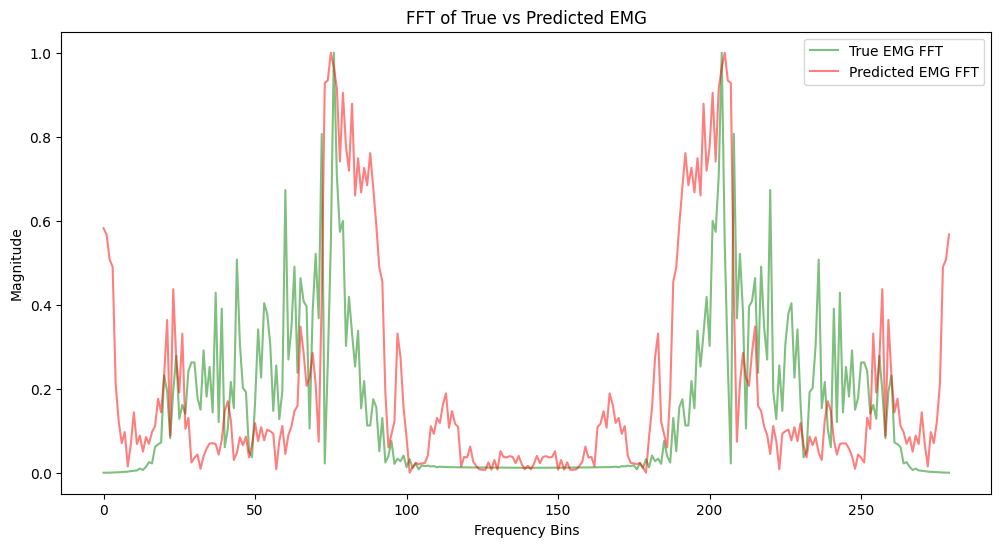

In [304]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

scaler1.fit(mag_true.reshape(-1, 1))
scaler2.fit(mag_pred.reshape(-1, 1))

mag_true_norm = scaler1.transform(mag_true.reshape(-1, 1)).flatten()
mag_pred_norm = scaler2.transform(mag_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(mag_true_norm, label='True EMG FFT', alpha=0.5, color='green')
plt.plot(mag_pred_norm, label='Predicted EMG FFT', alpha=0.5, color='red')
plt.title('FFT of True vs Predicted EMG')
plt.xlabel('Frequency Bins')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

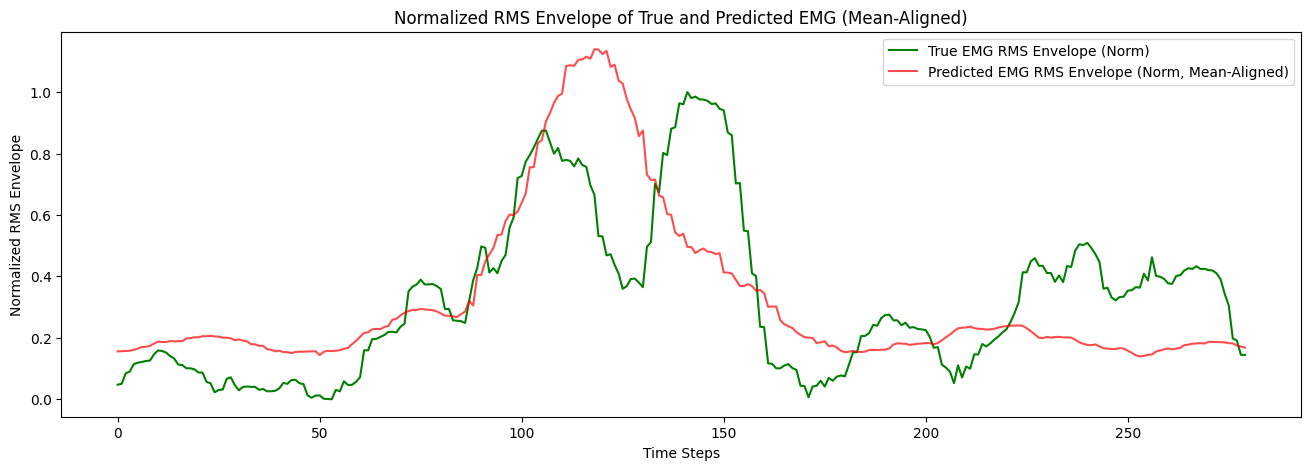

In [305]:
from scipy.signal import hilbert

def compute_rms_envelope(signal, window_size=20):
    # Compute RMS envelope using a moving window
    squared = np.square(signal.flatten())
    window = np.ones(window_size) / window_size
    rms = np.sqrt(np.convolve(squared, window, mode='same'))
    return rms

# Compute RMS envelopes
rms_true = compute_rms_envelope(true_emg)
rms_pred = compute_rms_envelope(pred_emg)

# Normalize RMS envelopes to [0, 1]
rms_scaler_true = MinMaxScaler()
rms_scaler_pred = MinMaxScaler()
rms_true_norm = rms_scaler_true.fit_transform(rms_true.reshape(-1, 1)).flatten()
rms_pred_norm = rms_scaler_pred.fit_transform(rms_pred.reshape(-1, 1)).flatten()

# Mean alignment: shift predicted to have same mean as true
mean_true = np.mean(rms_true_norm)
mean_pred = np.mean(rms_pred_norm)
rms_pred_norm_aligned = rms_pred_norm + (mean_true - mean_pred)

# Plot normalized, mean-aligned envelopes
plt.figure(figsize=(16, 5))
plt.plot(rms_true_norm, label='True EMG RMS Envelope (Norm)', color='green')
plt.plot(rms_pred_norm_aligned, label='Predicted EMG RMS Envelope (Norm, Mean-Aligned)', color='red', alpha=0.7)
plt.title('Normalized RMS Envelope of True and Predicted EMG (Mean-Aligned)')
plt.xlabel('Time Steps')
plt.ylabel('Normalized RMS Envelope')
plt.legend()
plt.show()


Wavelet Coherence Analysis (WCA)

In [306]:
# import numpy as np
# import pycwt as wavelet
# import matplotlib.pyplot as plt

# # Normalize the data
# x = (true_emg.flatten() - np.mean(true_emg)) / np.std(true_emg)
# y = (pred_emg.flatten() - np.mean(pred_emg)) / np.std(pred_emg)

# plt.close('all')
# plt.clf()
# plt.cla()

# # Define the mother wavelet
# mother = wavelet.Morlet(6)

# # Calculate wavelet coherence
# WCT, cross_spectrum, coi, freq, signif = wavelet.wct(
#     x, y, dt=1.0, dj=0.125, s0=2*1, J=-1, wavelet=mother
# )

# avg_coherence = np.nanmean(np.abs(WCT))
# print(f"Average wavelet coherence (PyCWT): {avg_coherence:.4f}")

# # Plot the coherence map
# plt.imshow(
#     np.abs(WCT), aspect='auto', origin='lower',
#     extent=[0, len(x), freq[0], freq[-1]], cmap='jet'
# )
# plt.colorbar(label='Wavelet Coherence')
# plt.xlabel('Time')
# plt.ylabel('Frequency')
# plt.title('Wavelet Coherence between True and Predicted EMG')
# plt.show()
